# Exploring employee reviews

In this notebook I'll take a look at the dataset published [here](https://www.kaggle.com/petersunga/google-amazon-facebook-employee-reviews) on employee reviews for some of the biggest US tech companies.

In [86]:
from sklearn.metrics.pairwise import cosine_similarity
from collections import Counter, defaultdict
from sklearn.manifold import TSNE
from nltk.corpus import stopwords
from nltk import word_tokenize

import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import numpy as np

import gensim
import os

## Data loading and cleanup

In [2]:
data_path = 'data/employee_reviews.csv'

In [3]:
df = pd.read_csv(data_path)

I'll start by doing some standard cleaning up of the dataset

In [4]:
df = df.drop(['Unnamed: 0', 'helpful-count', 'link'], axis=1)

Also, by taking a look at the data it seems clear that the `summary` field does not convey any useful information so I'll just drop it.

In [5]:
df = df.drop(['summary'], axis=1)

Here what the data looks like after the cleaning

In [6]:
df[:5]

,company,location,dates,job-title,pros,cons,advice-to-mgmt,overall-ratings,work-balance-stars,culture-values-stars,carrer-opportunities-stars,comp-benefit-stars,senior-mangemnet-stars
0,google,none,"Dec 11, 2018",Current Employee - Anonymous Employee,People are smart and friendly,Bureaucracy is slowing things down,none,5.0,4.0,5.0,5.0,4.0,5.0
1,google,"Mountain View, CA","Jun 21, 2013",Former Employee - Program Manager,"1) Food, food, food. 15+ cafes on main campus ...",1) Work/life balance. What balance? All those ...,1) Don't dismiss emotional intelligence and ad...,4.0,2.0,3.0,3.0,5.0,3.0
2,google,"New York, NY","May 10, 2014",Current Employee - Software Engineer III,"* If you're a software engineer, you're among ...","* It *is* becoming larger, and with it comes g...",Keep the focus on the user. Everything else wi...,5.0,5.0,4.0,5.0,5.0,4.0
3,google,"Mountain View, CA","Feb 8, 2015",Current Employee - Anonymous Employee,You can't find a more well-regarded company th...,I live in SF so the commute can take between 1...,Keep on NOT micromanaging - that is a huge ben...,5.0,2.0,5.0,5.0,4.0,5.0
4,google,"Los Angeles, CA","Jul 19, 2018",Former Employee - Software Engineer,Google is a world of its own. At every other c...,"If you don't work in MTV (HQ), you will be giv...",Promote managers into management for their man...,5.0,5.0,5.0,5.0,5.0,5.0


## Word2Vec model

One thing that would be interesting is to try to cluster the reviews based on their textual content.

To do that I'll load a Word2Vec pretrained model from Google using gensim.

In [9]:
model = gensim.models.KeyedVectors.load_word2vec_format(
    '/media/giorgio/inbar_hd/models/GoogleNews-vectors-negative300.bin', 
    binary=True
)  

Let's print out the vector for a random word to make sure the model was loaded correctly.

In [14]:
print(model['easy'][:5])

[ 0.12094994  0.02696336 -0.0631713   0.04718588 -0.002588  ]


In [12]:
# This saves up memory
model.init_sims(replace=True)

## Data preprocessing

Before we can actually use the pretrained model to vectorize our corpus of reviews, we should preprocess the data to make it more manageable. I'll also stitch together the three sections of each review in a single string.

In [53]:
pros = list(df['pros'])
cons = list(df['cons'])
advm = list(df['advice-to-mgmt'])

There seems to be a few entries of the advice to management section being misinterpreted as floats.

In [54]:
for i in range(len(pros)):
    if type(pros[i]) is not str or type(cons[i]) is not str or type(advm[i]) is not str:
        print(pros[i], cons[i], advm[i])
        print('-'*80)
        break

Lots of learning opportunities at here not for now, everything is good. nan
--------------------------------------------------------------------------------


In [55]:
if len(pros) == len(cons) and len(cons) == len(advm):
    revs = [str(pros[i]) + ' ' + str(cons[i]) + ' ' + str(advm[i]) for i in range(len(pros))] 
else:
    print('Different number of reviews')

In [56]:
print(revs[0])

People are smart and friendly Bureaucracy is slowing things down none


We can now use nltk to tokenize and remove stopwords

In [57]:
stop_words = stopwords.words('english')

In [64]:
revs_pre = [[word.lower() for word in word_tokenize(doc) if word.lower() not in stop_words] for doc in revs]

In [59]:
revs_pre = [doc[:-1] if doc[-1] in ['none', 'nan'] else doc for doc in revs_pre]

In [60]:
print(revs_pre[0])

['people', 'smart', 'friendly', 'bureaucracy', 'slowing', 'things']


We will also need to remove words not in the model's dictionary

In [61]:
revs_fin = []
for doc in revs_pre:
    doc = [word for word in revs_pre[i] if word in model.vocab]
    if not doc: continue
    revs_fin.append(doc)

In [65]:
print(len(revs), len(revs_pre), len(revs_fin))

67529 67529 67529


## Document vector embedding

Now let's find out the centroid for each document

In [66]:
centroids = [np.mean(model[doc], axis=0) for doc in revs_fin]

In [68]:
len(centroids[0])

300

Now that we have our 300-dimensional document centroid embeddings we can use a dimensionality reduction technique such as tsne to obtain a 2D representation of the data.

In [74]:
cents_embed = TSNE(n_components=2).fit_transform(centroids)

In [76]:
print(len(cents_embed), cents_embed[0])

67529 [-0.04790577 -0.04777134]


Let's save the results on disk, since losing them would mean wasting a few hours of computation.

In [78]:
np.save(open('res/tsne_review_centroids', 'wb'), cents_embed)

## TSNE

Let's see a preliminary version of the scatter plot

In [109]:
comp = list(df['company'])
comp_order = {sorted(list(set(comp)))[i]: i for i in range(len(set(comp)))}
comp_c = [comp_order[c] for c in comp]
c_comp = []
x_crd = []
y_crd = []
for c in cents_embed:
    x_crd.append(c[0])
    y_crd.append(c[1])

In [116]:
Counter(comp_c).most_common()

[(0, 26430), (4, 17930), (1, 12950), (3, 7819), (2, 1590), (5, 810)]

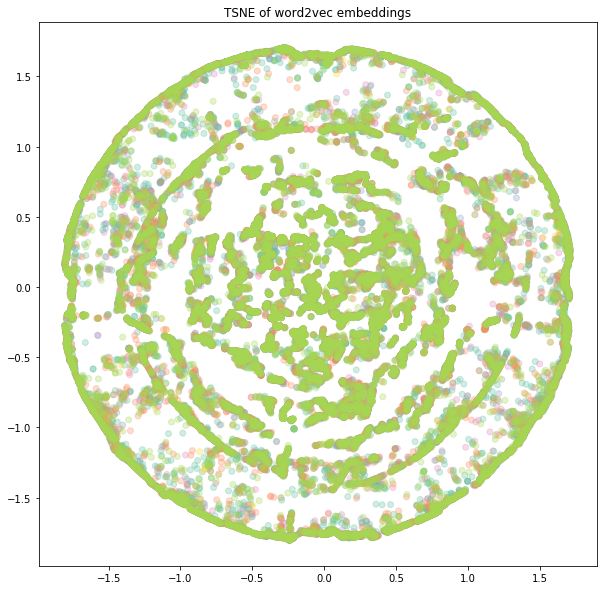

In [120]:
fig, ax = plt.subplots(1,1, figsize=(10,10))
cmap = plt.cm.get_cmap('Set2')
cmaplist = [cmap(i) for i in range(len(set(comp)))]

graph = plt.scatter(x_crd, y_crd, c=comp_c, label=comp, cmap=mpl.colors.ListedColormap(cmaplist), alpha=0.3)
# cb = plt.colorbar(graph, spacing='proportional',ticks=sorted(list(set(comp))))
ax.set_title('TSNE of word2vec embeddings')
plt.show()

## Splitting by date

This representation unfortunately is not really helpful due to the huge amount of data points.

Let's try to scale the problem to a more manageable size by dividing the reviews by year.

In [124]:
date = list(df['dates'])

' Dec 11, 2018'

## Star ratings

In addition to the reviews it would also be interesting to know the star ratings count for each company

In [79]:
comp = list(df['company'])
ovrl = list(df['overall-ratings'])

In [84]:
star = defaultdict(Counter)
for i in range(len(comp)):
    star[comp[i]][ovrl[i]] += 1

In [85]:
star

defaultdict(collections.Counter,
            {'google': Counter({5.0: 4378,
                      4.0: 2275,
                      3.0: 763,
                      2.0: 248,
                      1.0: 155}),
             'amazon': Counter({5.0: 7553,
                      3.0: 5574,
                      4.0: 8091,
                      2.0: 2751,
                      1.0: 2461}),
             'facebook': Counter({5.0: 1151,
                      2.0: 49,
                      3.0: 98,
                      1.0: 47,
                      4.0: 245}),
             'netflix': Counter({5.0: 240,
                      3.0: 133,
                      2.0: 112,
                      4.0: 205,
                      1.0: 120}),
             'apple': Counter({5.0: 4805,
                      4.0: 4581,
                      3.0: 2266,
                      2.0: 814,
                      1.0: 484}),
             'microsoft': Counter({5.0: 5063,
                      4.0: 7101,
                  